Model: "fallen_detector_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv)                  (1, 74, 74, 32)           1024      
_________________________________________________________________
conv_1 (Conv)                (1, 36, 36, 64)           18752     
_________________________________________________________________
conv_2 (Conv)                (1, 17, 17, 128)          74368     
_________________________________________________________________
conv_3 (Conv)                (1, 7, 7, 128)            148096    
_________________________________________________________________
flatten (Flatten)            (1, 6272)                 0         
_________________________________________________________________
dense (Dense)                (1, 512)                  3211776   
_________________________________________________________________
dense_1 (Dense)              (1, 2)            

C:\Users\ELINA_~1\AppData\Local\Temp/ipykernel_16152/3310107703.py:224: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


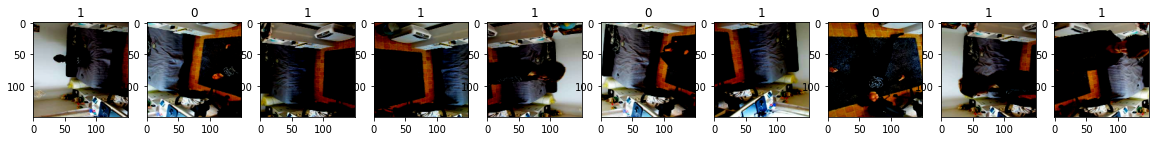

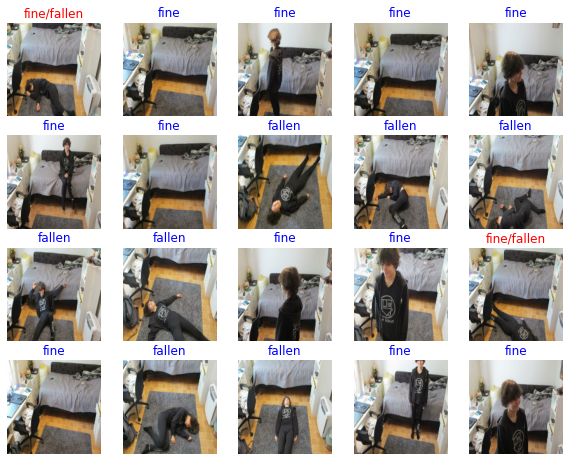

In [1]:
import os
#import time
#import re
from glob import glob
#import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
#from PIL import Image
%matplotlib inline

folder = 'C:\\Users\\Elina_UNI\\Documents\\snh_things\\dataset\\'

def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    # Decode it to JPEG format
    image = tf.image.decode_jpeg(image)
    # Convert it to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label 

def resize(input_image, size):
    return tf.image.resize(input_image, size)

def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[150, 150, 3])

def central_crop(input_image):
    image = resize(input_image, [176, 176])
    return tf.image.central_crop(image, central_fraction=0.84)

def random_rotation(input_image):
    angles = np.random.randint(0, 3, 1)
    return tf.image.rot90(input_image, k=angles[0])

def random_jitter(input_image):
    # Resize it to 176 x 176 x 3
    image = resize(input_image, [176, 176])
    # Randomly Crop to 150 x 150 x 3
    image = random_crop(image)
    # Randomly rotation
    image = random_rotation(image)
    # Randomly mirroring
    image = tf.image.random_flip_left_right(image)
    return image 

def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image)) / 2
    input_image = input_image / mid - 1
    return input_image 

def load_image_train(image_file, label):
    image, label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image, label

def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

# Training dataset
temp_ds = tf.data.Dataset.list_files(os.path.join(folder + 'train\\fallen\\', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join(folder + 'train\\fine\\', '*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

train_ds = temp_ds.concatenate(temp2_ds)

buffer_size = tf.data.experimental.cardinality(train_ds).numpy()
train_ds = train_ds.shuffle(buffer_size) \
                   .map(load_image_train, num_parallel_calls=16) \
                   .batch(20) \
                   .repeat()

# Validation dataset
temp_ds = tf.data.Dataset.list_files(os.path.join(folder + 'val\\fallen\\', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join(folder + 'val\\fine\\', '*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

val_ds = temp_ds.concatenate(temp2_ds)

val_ds = val_ds.map(load_image_val, num_parallel_calls=16)\
               .batch(20)\
               .repeat()

# Test dataset
temp_ds = tf.data.Dataset.list_files(os.path.join(folder + 'test\\fallen\\', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join(folder + 'test\\fine\\', '*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

test_ds = temp_ds.concatenate(temp2_ds)

test_ds = test_ds.map(load_image_val, num_parallel_calls=16)\
                .shuffle(buffer_size)\
               .batch(20)\
               .repeat()

# What are you?
# What do you do?
'''
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 6))
    for j in range(10):
        image = images[j].numpy()
        image = image / np.amax(image)
        image = np.clip(image, 0, 1)
        ax[j].imshow(image)
        ax[j].set_title(labels[j].numpy())
'''

class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        return x

model = tf.keras.Sequential(name='fallen_detector_cnn')

model.add(Conv(filters=32, kernel_size=(3, 3)))
model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

model(images[:1])

checkpoint_path = folder + "fallen_detector_cnn\\cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

train_len = len(glob(os.path.join(folder + 'train\\fallen\\', '*.jpg'))) * 2
val_len = len(glob(os.path.join(folder + 'val\\fallen\\', '*.jpg'))) * 2
test_len = len(glob(os.path.join(folder + 'test\\fallen\\', '*.jpg'))) * 2

# Training
'''
model.fit(train_ds, steps_per_epoch=train_len / 20,
          validation_data=val_ds,
          validation_steps=val_len / 20,
          epochs=30,
          callbacks=[cp_callback]
          )
'''
#quit()
model.evaluate(test_ds, steps=test_len / 20)


model_inf = tf.keras.Sequential(name='fallen_detector_CNN_load')

model_inf.add(Conv(filters=32, kernel_size=(3, 3)))
model_inf.add(Conv(filters=64, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3)))

model_inf.add(tf.keras.layers.Flatten())  
model_inf.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu)) 
model_inf.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))  

model_inf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])

for images, labels in train_ds.take(1):
    outputs = model_inf(images, training=False)

# Load model
model_inf.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_inf.evaluate(test_ds, steps=test_len / 20)

test_batch_size = 25

for images, labels in test_ds.take(1):
    predictions = model_inf(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'fallen', 1: 'fine'}

fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')
fig.show()
